# Setup Environment

If you are working on this assignment using Google Colab, please execute the codes below.

Alternatively, you can also do this assignment using a local anaconda environment (or a Python virtualenv). Please clone the GitHub repo by running `git clone https://github.com/Berkeley-CS182/cs182hw3.git` and refer to `README.md` for further details.

In [1]:
#@title Mount your Google Drive

import os
'''
from google.colab import drive
drive.mount('/content/gdrive')
'''

"\nfrom google.colab import drive\ndrive.mount('/content/gdrive')\n"

In [ ]:
#@title Set up mount symlink

DRIVE_PATH = '/content/gdrive/My\ Drive/cs182hw3_sp23'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/cs182hw3'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

In [ ]:
#@title Install dependencies

!pip install numpy==1.21.6 imageio==2.9.0 matplotlib==3.2.2

In [ ]:
#@title Clone homework repo

%cd $SYM_PATH
if not os.path.exists("cs182hw3"):
  !git clone https://github.com/Berkeley-CS182/cs182hw3.git
%cd cs182hw3

In [ ]:
#@title Download datasets

%cd deeplearning/datasets/
!bash ./get_datasets.sh
%cd ../..

In [2]:
#@title Configure Jupyter Notebook

import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Batch Normalization
One way to make deep networks easier to train is to use more sophisticated optimization procedures such as SGD+momentum, RMSProp, or Adam. Another strategy is to change the architecture of the network to make it easier to train. One idea along these lines is batch normalization which was proposed by [1].

The idea is relatively straightforward. Machine learning methods tend to work better when their input data consists of uncorrelated features with zero mean and unit variance. When training a neural network, we can preprocess the data before feeding it to the network to explicitly decorrelate its features; this will ensure that the first layer of the network sees data that follows a nice distribution. However even if we preprocess the input data, the activations at deeper layers of the network will likely no longer be decorrelated and will no longer have zero mean or unit variance since they are output from earlier layers in the network. Even worse, during the training process the distribution of features at each layer of the network will shift as the weights of each layer are updated.

The authors of [1] hypothesize that the shifting distribution of features inside deep neural networks may make training deep networks more difficult. To overcome this problem, [1] proposes to insert batch normalization layers into the network. At training time, a batch normalization layer uses a minibatch of data to estimate the mean and standard deviation of each feature. These estimated means and standard deviations are then used to center and normalize the features of the minibatch. A running average of these means and standard deviations is kept during training, and at test time these running averages are used to center and normalize features.

It is possible that this normalization strategy could reduce the representational power of the network, since it may sometimes be optimal for certain layers to have features that are not zero-mean or unit variance. To this end, the batch normalization layer includes learnable shift and scale parameters for each feature dimension.

[1] Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.

In [37]:
# As usual, a bit of setup

import os
import time
import numpy as np
import matplotlib.pyplot as plt
from deeplearning.classifiers.fc_net import *
from deeplearning.data_utils import get_CIFAR10_data
from deeplearning.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from deeplearning.solver import Solver
import random 
import torch
seed = 7
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

os.makedirs("submission_logs", exist_ok=True)

def abs_error(x, y):
    return np.max(np.abs(x - y))

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [4]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
    print ('%s: ' % k, v.shape)

deeplearning/datasets/cifar-10-batches-py/data_batch_1
deeplearning/datasets/cifar-10-batches-py/data_batch_2
deeplearning/datasets/cifar-10-batches-py/data_batch_3
deeplearning/datasets/cifar-10-batches-py/data_batch_4
deeplearning/datasets/cifar-10-batches-py/data_batch_5
deeplearning/datasets/cifar-10-batches-py/test_batch
X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


The forward propagation during training given input $\mathbf{X}\in\mathbb{R}^{n,d}$ is defined as:

$$\begin{aligned}
\mu_j &= \dfrac1n \sum_{i=1}^n X_{i,j} \\
\sigma^2_j &= \dfrac{1}{n} \sum_{i=1}^n (X_{i,j} - \mu_j)^2 \\
Y_{i,j} &= \mathrm{BN}(\mathbf{X}|\gamma, \beta)_{i,j} = \dfrac{X_{i,j} - \mu_j}{\sqrt{\sigma^2_j + \epsilon}}\gamma_j + \beta_j
\end{aligned}$$

It would be helpful if you introduce another intermediate variable $\mathbf{Z}\in\mathbb{R}^{n,d}$:

$$\begin{aligned}
\mu_j &= \dfrac1n \sum_{i=1}^n X_{i,j} \\
\sigma^2_j &= \dfrac{1}{n} \sum_{i=1}^n (X_{i,j} - \mu_j)^2 \\
Z_{i,j} &= \dfrac{X_{i,j} - \mu_j}{\sqrt{\sigma^2_j + \epsilon}} \\
Y_{i,j} &= \mathrm{BN}(\mathbf{X}|\gamma, \beta)_{i,j} = Z_{i,j}\gamma_j + \beta_j
\end{aligned}$$

### Question

**Draw the computational graph of training-time batch normalization** in your written assignment. In input of the computational graph should be $\mathbf{X}, \gamma, \beta$, the output of the computational graph should be $\mathbf{Y}$, and the intermediate nodes are $\mu, \sigma^2, \mathbf{Z}$.



## Batch normalization: Forward

In the file `deeplearning/layers.py`, implement the batch normalization forward pass in the function `batchnorm_forward`. 

Don't forget to record batch statistics such as running mean/var during training.

During testing, $\mu$, and $\sigma^2$ are running mean and variance that is previously recorded in the training process.

Once you have done so, run the following to test your implementation.

In [6]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization

# Simulate the forward pass for a two-layer network
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print ('Before batch normalization:')
print ('  means: ', a.mean(axis=0))
print ('  stds: ', a.std(axis=0))

# Means should be close to zero and stds close to one
print ('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
print ('  mean: ', a_norm.mean(axis=0))  # expected: (approx.) [0, 0, 0]
print ('  std: ', a_norm.std(axis=0))  # expected: (approx.) [1, 1, 1]

# Now means should be close to beta and stds close to gamma
gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print ('After batch normalization (nontrivial gamma, beta)')
print ('  means: ', a_norm.mean(axis=0))  # expected: (approx.) [11, 12, 13]
print ('  stds: ', a_norm.std(axis=0))  # expected: (approx.) [1, 2, 3]

Before batch normalization:
  means:  [-33.90168215  18.46269328  -7.49068667]
  stds:  [38.72112268 29.39668975 31.14272252]
After batch normalization (gamma=1, beta=0)
  mean:  [4.62963001e-16 8.99280650e-17 3.88578059e-18]
  std:  [1.         0.99999999 0.99999999]
After batch normalization (nontrivial gamma, beta)
  means:  [11. 12. 13.]
  stds:  [1.         1.99999999 2.99999998]


In [7]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
N, D1, D2, D3 = 200, 50, 60, 3
np.random.seed(seed)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)
for t in range(50):
    X = np.random.randn(N, D1)
    a = np.maximum(0, X.dot(W1)).dot(W2)
    batchnorm_forward(a, gamma, beta, bn_param)
bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print ('After batch normalization (test-time):')
print ('  means: ', a_norm.mean(axis=0))
print ('  stds: ', a_norm.std(axis=0))
expected_a_norm = np.array(
    [[-7.37859885e-01,  2.10050591e+00, -3.24286480e-01],
    [ 2.02781031e+00,  1.92492178e-01,  1.54852388e+00],
    [ 5.44242949e-01,  1.07389911e+00,  8.06464618e-01],
    [-2.25599789e-02,  7.64501325e-01, -3.03045313e-01],
    [-9.74592587e-01,  6.01731799e-01, -6.57200019e-03]])
print ('Abs error of a_norm: ', abs_error(a_norm[:5, :], expected_a_norm))

After batch normalization (test-time):
  means:  [-0.00967681  0.01315673  0.00748036]
  stds:  [1.07009997 1.01651564 0.88995918]
Abs error of a_norm:  4.3424073226105975e-09


## Batch Normalization: backward
Now implement the backward pass for batch normalization in the function `batchnorm_backward`.

To derive the backward pass you should refer to the computation graph for batch normalization and backprop through each of the intermediate nodes that you have drawn earlier. Some intermediates may have multiple outgoing branches; make sure to sum gradients across these branches in the backward pass.

Once you have finished, run the following to numerically check your backward pass.

In [15]:
# Gradient check batchnorm backward pass

N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda gamma: batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda beta: batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
print ('dx error: ', rel_error(dx_num, dx))
print ('dgamma error: ', rel_error(da_num, dgamma))
print ('dbeta error: ', rel_error(db_num, dbeta))

dx error:  6.2796519493592375e-09
dgamma error:  5.065869405640102e-11
dbeta error:  4.119979819293138e-11


## Batch Normalization: alternative backward (Optional)
There are two strategies to implement batch normalization of an operator consists of multiple parts:

1. Write out a computation graph composed of simple operations and backprop through all intermediate values. This is the general principal of automatic backpropagation in deep learning framework.

1. Work out the derivatives on paper. This usually applies to some operators to achieve better numerical stability or computational efficiency, such as `softmax + cross entropy` or `sigmoid + binary cross entropy`.

Surprisingly, it turns out that you can also derive a simple expression for the batch normalization backward pass if you work out derivatives on paper and simplify.

### Question (Optional)
**Derive the closed-form back-propagation of a batch normalization layer (during training).** Include the answer in your written assignment.

Specifically, given $\mathrm{dy}_{i,j} = \dfrac{\partial \mathcal{L}}{\partial Y_{i,j}}$ for every $i,j$, Please derive $\dfrac{\partial \mathcal{L}}{\partial X_{i,j}}$ for every $i,j$ as a function of $\mathrm{dy}, \mathbf{X}, \mu, \sigma^2, \epsilon, \gamma, \beta$.


After doing so (and additionally deriving $\dfrac{\partial \mathcal{L}}{\partial \gamma_j}$ and $\dfrac{\partial \mathcal{L}}{\partial \beta_j}$ for each $j$), implement the simplified batch normalization backward pass in the function `batchnorm_backward_alt` and compare the two implementations by running the following. Your two implementations should compute nearly identical results, but the alternative implementation should be a bit faster.

In [ ]:
N, D = 100, 500
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
out, cache = batchnorm_forward(x, gamma, beta, bn_param)

t1 = time.time()
# repeat backwards passes multiple times for stability
for r in range(1000):
    dx1, dgamma1, dbeta1 = batchnorm_backward(dout, cache)
t2 = time.time()
for r in range(1000):
    dx2, dgamma2, dbeta2 = batchnorm_backward_alt(dout, cache)
t3 = time.time()

print ('dx difference: ', rel_error(dx1, dx2))
print ('dgamma difference: ', rel_error(dgamma1, dgamma2))
print ('dbeta difference: ', rel_error(dbeta1, dbeta2))
print ('speedup: %.2fx' % ((t2 - t1) / (t3 - t2)))

## Fully Connected Nets with Batch Normalization
Now that you have a working implementation for batch normalization, go back to your `FullyConnectedNet` in the file `deeplearning/classifiers/fc_net.py`. Modify your implementation to add batch normalization.

Concretely, when the flag `use_batchnorm` is `True` in the constructor, you should insert a batch normalization layer before each ReLU nonlinearity. The outputs from the last layer of the network should not be normalized. Once you are done, run the following to gradient-check your implementation.

HINT: You might find it useful to define an additional helper layer similar to those in the file `deeplearning/layer_utils.py`. If you decide to do so, do it in the file `deeplearning/classifiers/fc_net.py`.

In [23]:
N, D, H1, H2, C = 2, 15, 20, 30, 10

model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=0, weight_scale=5e-2, dtype=np.float64,
                            use_batchnorm=True)
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H1).reshape(D, H1)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H1)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H1*H2).reshape(H1, H2)
model.params['b2'] = np.linspace(-0.9, 0.1, num=H2)
model.params['W3'] = np.linspace(-0.3, 0.4, num=H2*C).reshape(H2, C)
model.params['b3'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T

expected_bn_forward_output = np.array([[0.28397701, 0.46532063, 0.64666426, 0.82800788, 1.0093515, 1.19069513,
                                            1.37203875, 1.55338238,  1.734726, 1.91606962],
                                       [-0.9, -0.78888889, -0.67777778, -0.56666667, -0.45555556, -0.34444444, 
                                            -0.23333333, -0.12222222, -0.01111111, 0.1]])

# Checks if initial forward pass is correct with batchnorm 
init_scores = model.loss(X)
print('initial predictions error: %.2e' % rel_error(init_scores, expected_bn_forward_output))

X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print ('Running check with reg = ', reg)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64,
                            use_batchnorm=True)
    
    
    loss, grads = model.loss(X, y)
    print ('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print ('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    if reg == 0: print

initial predictions error: 5.00e-08
Running check with reg =  0
Initial loss:  2.136692029323493
W1 relative error: 1.17e-05
W2 relative error: 1.36e-04
W3 relative error: 3.15e-10
b1 relative error: 4.44e-08
b2 relative error: 3.89e-08
b3 relative error: 8.72e-11
beta1 relative error: 4.17e-09
beta2 relative error: 1.37e-08
gamma1 relative error: 7.06e-09
gamma2 relative error: 2.37e-08
Running check with reg =  3.14
Initial loss:  6.954854389737268
W1 relative error: 1.50e-06
W2 relative error: 4.04e-06
W3 relative error: 4.36e-09
b1 relative error: 3.55e-07
b2 relative error: 1.11e-07
b3 relative error: 1.96e-10
beta1 relative error: 1.05e-08
beta2 relative error: 4.69e-09
gamma1 relative error: 1.04e-08
gamma2 relative error: 6.08e-09


## Batchnorm for deep networks
Run the following to train a six-layer network on a subset of 1000 training examples both with and without batch normalization.

In [24]:
#debugging
from deeplearning.layers import *
from deeplearning.classifiers.fc_net import *

# Try training a very deep net with batchnorm
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)
np.random.seed(seed)
bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
bn_solver.train()

np.random.seed(seed)
solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
solver.train()

(Iteration 1 / 200) loss: 2.372211
(Epoch 0 / 10) train acc: 0.159000; val_acc: 0.125000
(Epoch 1 / 10) train acc: 0.338000; val_acc: 0.268000
(Epoch 2 / 10) train acc: 0.438000; val_acc: 0.323000
(Epoch 3 / 10) train acc: 0.502000; val_acc: 0.336000
(Epoch 4 / 10) train acc: 0.560000; val_acc: 0.340000
(Epoch 5 / 10) train acc: 0.621000; val_acc: 0.334000
(Epoch 6 / 10) train acc: 0.634000; val_acc: 0.318000
(Epoch 7 / 10) train acc: 0.707000; val_acc: 0.340000
(Epoch 8 / 10) train acc: 0.739000; val_acc: 0.329000
(Epoch 9 / 10) train acc: 0.753000; val_acc: 0.315000
(Epoch 10 / 10) train acc: 0.775000; val_acc: 0.331000
(Iteration 1 / 200) loss: 2.303226
(Epoch 0 / 10) train acc: 0.147000; val_acc: 0.131000
(Epoch 1 / 10) train acc: 0.165000; val_acc: 0.160000
(Epoch 2 / 10) train acc: 0.292000; val_acc: 0.259000
(Epoch 3 / 10) train acc: 0.328000; val_acc: 0.263000
(Epoch 4 / 10) train acc: 0.384000; val_acc: 0.273000
(Epoch 5 / 10) train acc: 0.428000; val_acc: 0.306000
(Epoch 6 / 

Run the following to visualize the results from two networks trained above and record the results of the experiment. You should find that using batch normalization helps the network to converge faster.

/tmp/ipykernel_3310/2858957588.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3, 1, 1)
/tmp/ipykernel_3310/2858957588.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3, 1, 2)
/tmp/ipykernel_3310/2858957588.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be crea

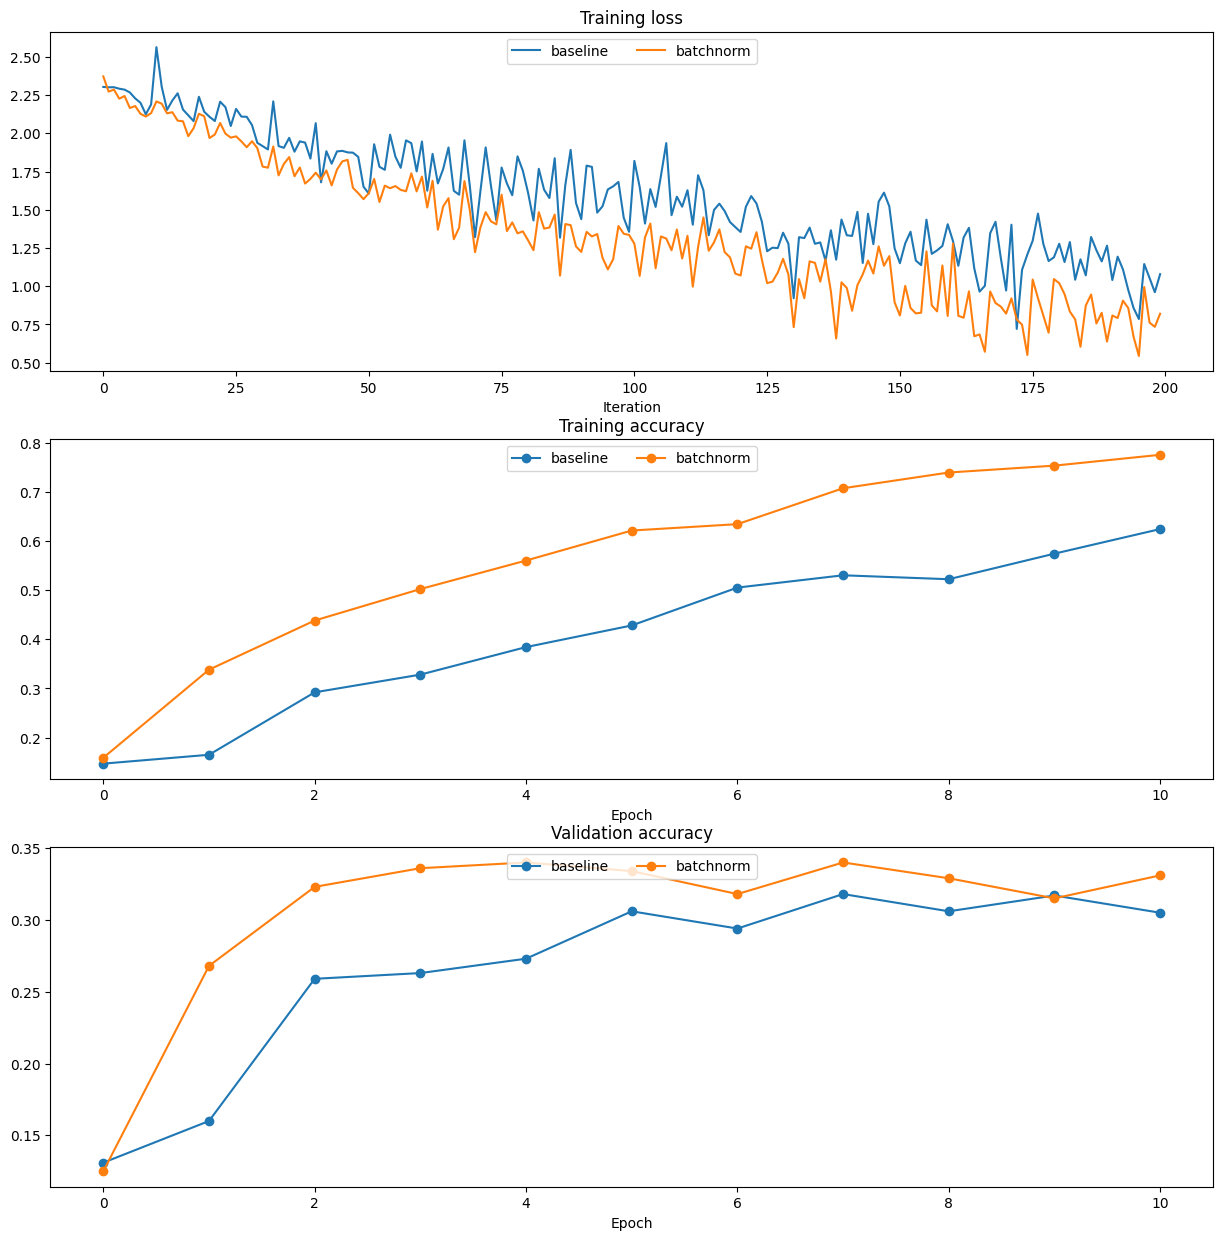

In [25]:
plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 1)
plt.plot(solver.loss_history, '-', label='baseline')
plt.plot(bn_solver.loss_history, '-', label='batchnorm')

plt.subplot(3, 1, 2)
plt.plot(solver.train_acc_history, '-o', label='baseline')
plt.plot(bn_solver.train_acc_history, '-o', label='batchnorm')

plt.subplot(3, 1, 3)
plt.plot(solver.val_acc_history, '-o', label='baseline')
plt.plot(bn_solver.val_acc_history, '-o', label='batchnorm')
  
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

solver.record_histories_as_npz('submission_logs/compare_bn_deep_networks_no_bn.npz')
bn_solver.record_histories_as_npz('submission_logs/compare_bn_deep_networks_with_bn.npz')

## Batch normalization and initialization
We will now run a small experiment to study the interaction of batch normalization and weight initialization.

The first cell will train 8-layer networks both with and without batch normalization using different scales for weight initialization. The second layer will plot training accuracy, validation set accuracy, and training loss as a function of the weight initialization scale.

In [26]:
# Try training a very deep net with batchnorm
hidden_dims = [50, 50, 50, 50, 50, 50, 50]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

bn_solvers = {}
solvers = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
    print ('Running weight scale %d / %d' % (i + 1, len(weight_scales)))
    bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

    np.random.seed(seed)
    bn_solver = Solver(bn_model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
    bn_solver.train()
    bn_solvers[weight_scale] = bn_solver

    np.random.seed(seed)
    solver = Solver(model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
    solver.train()
    solvers[weight_scale] = solver

Running weight scale 1 / 20
Running weight scale 2 / 20
Running weight scale 3 / 20
Running weight scale 4 / 20
Running weight scale 5 / 20
Running weight scale 6 / 20
Running weight scale 7 / 20
Running weight scale 8 / 20
Running weight scale 9 / 20
Running weight scale 10 / 20
Running weight scale 11 / 20
Running weight scale 12 / 20
Running weight scale 13 / 20
Running weight scale 14 / 20
Running weight scale 15 / 20
Running weight scale 16 / 20
Running weight scale 17 / 20


/home/fhy/Desktop/cs182hw3/deeplearning/classifiers/fc_net.py:284: RuntimeWarning: overflow encountered in exp
  E = np.exp(r) #E of size (N, C)
/home/fhy/Desktop/cs182hw3/deeplearning/classifiers/fc_net.py:286: RuntimeWarning: invalid value encountered in true_divide
  S = E / _sum #S of size (N, C)
/home/fhy/Desktop/cs182hw3/deeplearning/classifiers/fc_net.py:290: RuntimeWarning: divide by zero encountered in log
  loss = (np.sum((0 - np.log(S)) * Y))/ X.shape[0]
/home/fhy/Desktop/cs182hw3/deeplearning/classifiers/fc_net.py:290: RuntimeWarning: invalid value encountered in multiply
  loss = (np.sum((0 - np.log(S)) * Y))/ X.shape[0]


Running weight scale 18 / 20
Running weight scale 19 / 20
Running weight scale 20 / 20


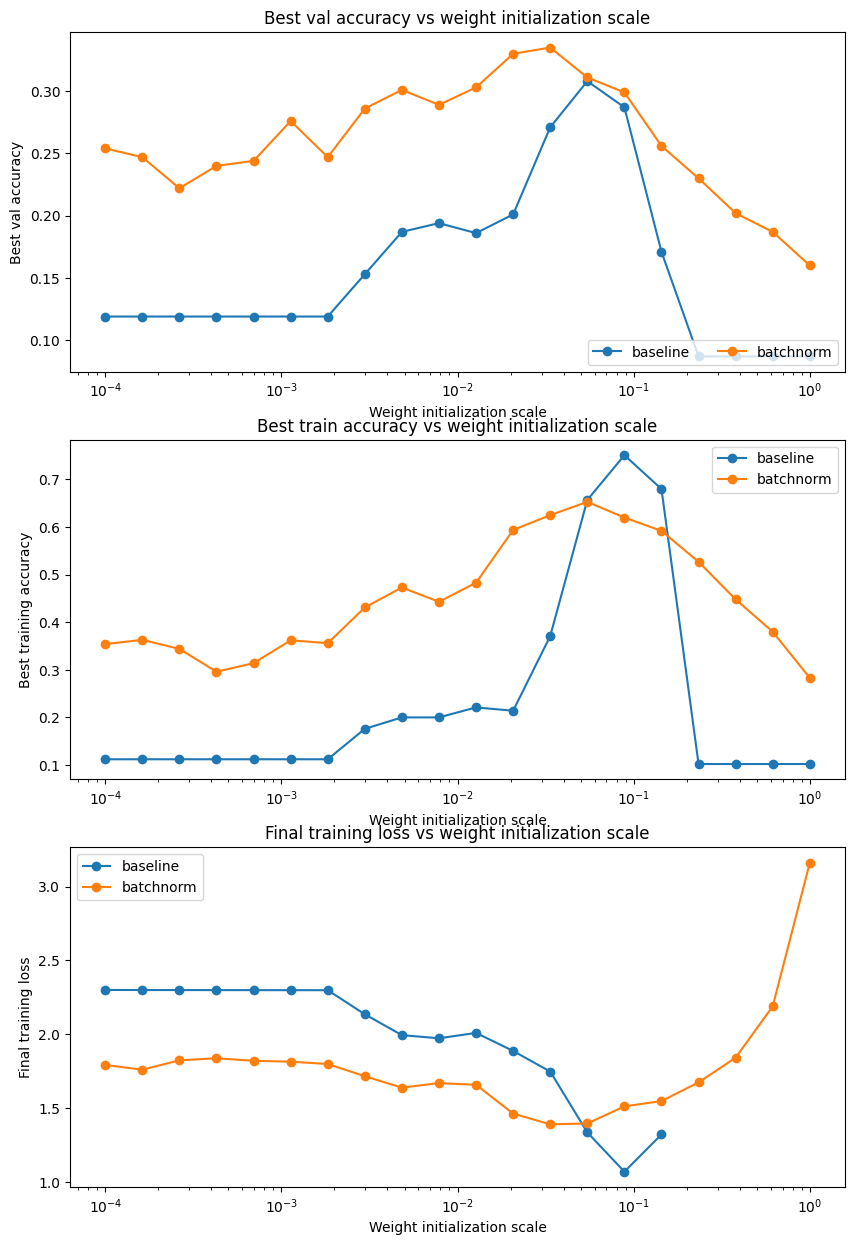

In [27]:
# Plot results of weight scale experiment
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for i, ws in enumerate(weight_scales):
    best_train_accs.append(max(solvers[ws].train_acc_history))
    bn_best_train_accs.append(max(bn_solvers[ws].train_acc_history))

    best_val_accs.append(max(solvers[ws].val_acc_history))
    bn_best_val_accs.append(max(bn_solvers[ws].val_acc_history))

    final_train_loss.append(np.mean(solvers[ws].loss_history[-100:]))
    bn_final_train_loss.append(np.mean(bn_solvers[ws].loss_history[-100:]))
    
    
    solvers[ws].record_histories_as_npz('submission_logs/bn_and_weight_scale_experiments_scale{}_no_bn.npz'.format(i))
    bn_solvers[ws].record_histories_as_npz('submission_logs/bn_and_weight_scale_experiments_scale{}_with_bn.npz'.format(i))

plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()

plt.gcf().set_size_inches(10, 15)
plt.show()

# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012

## Dropout forward pass
In the file `deeplearning/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes. Input means should be approximately the same as the output means at both train/test time.

Once you have done so, run the cell below to test your implementation.

In [31]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

    print ('Running tests with p = ', p)
    print ('Mean of input: ', x.mean())
    # expected: (approx.) 10, 10, 10
    print ('Mean of train-time output: ', out.mean())
    # expected: (approx.) 10, 10, 10
    print ('Mean of test-time output: ', out_test.mean())
    # expected: (approx.) 10, 10, 10
    print ('Fraction of train-time output set to zero: ', (out == 0).mean())
    # expected: (approx.) 0.3, 0.6, 0.75
    print ('Fraction of test-time output set to zero: ', (out_test == 0).mean())
    # expected: (approx.) 0.0, 0.0, 0.0

Running tests with p =  0.3
Mean of input:  9.999965771906316
Mean of train-time output:  10.004189135324738
Mean of test-time output:  9.999965771906316
Fraction of train-time output set to zero:  0.299696
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.6
Mean of input:  9.999965771906316
Mean of train-time output:  9.990284899924799
Mean of test-time output:  9.999965771906316
Fraction of train-time output set to zero:  0.600388
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.75
Mean of input:  9.999965771906316
Mean of train-time output:  10.006048238178446
Mean of test-time output:  9.999965771906316
Fraction of train-time output set to zero:  0.74996
Fraction of test-time output set to zero:  0.0


## Dropout backward pass
In the file `deeplearning/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [36]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print ('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  1.8929093207380182e-11


## Fully-connected nets with Dropout
In the file `deeplearning/classifiers/fc_net.py`, modify your implementation to use dropout. Specificially, if the constructor the the net receives a nonzero value for the `dropout` parameter, then the net should add dropout immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

In [39]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
    print ('Running check with dropout = ', dropout)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)
    
    loss, grads = model.loss(X, y)
    print ('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print ('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    print

Running check with dropout =  0
Initial loss:  2.303043161170242
W1 relative error: 4.80e-07
W2 relative error: 1.97e-07
W3 relative error: 1.93e-07
b1 relative error: 2.03e-08
b2 relative error: 1.69e-09
b3 relative error: 1.50e-10
Running check with dropout =  0.25
Initial loss:  2.305774818835151
W1 relative error: 4.83e-08
W2 relative error: 1.18e-06
W3 relative error: 1.51e-07
b1 relative error: 6.85e-09
b2 relative error: 8.87e-09
b3 relative error: 9.70e-11
Running check with dropout =  0.5
Initial loss:  2.2994400290646637
W1 relative error: 4.00e-08
W2 relative error: 8.88e-08
W3 relative error: 2.80e-08
b1 relative error: 4.33e-09
b2 relative error: 8.03e-10
b3 relative error: 1.50e-10


## Regularization experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a dropout probability of 0.5. We will then visualize the training and validation accuracies of the two networks over time.

In [40]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.5]
for dropout in dropout_choices:
    model = FullyConnectedNet([500], dropout=dropout)
    print (dropout)

    np.random.seed(seed)
    solver = Solver(model, small_data,
                  num_epochs=15, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
    solver.train()
    solvers[dropout] = solver

0
(Iteration 1 / 75) loss: 9.289189
(Epoch 0 / 15) train acc: 0.244000; val_acc: 0.175000
(Epoch 1 / 15) train acc: 0.356000; val_acc: 0.231000
(Epoch 2 / 15) train acc: 0.476000; val_acc: 0.230000
(Epoch 3 / 15) train acc: 0.594000; val_acc: 0.263000
(Epoch 4 / 15) train acc: 0.664000; val_acc: 0.274000
(Epoch 5 / 15) train acc: 0.778000; val_acc: 0.267000
(Epoch 6 / 15) train acc: 0.758000; val_acc: 0.281000
(Epoch 7 / 15) train acc: 0.842000; val_acc: 0.268000
(Epoch 8 / 15) train acc: 0.894000; val_acc: 0.276000
(Epoch 9 / 15) train acc: 0.920000; val_acc: 0.288000
(Epoch 10 / 15) train acc: 0.928000; val_acc: 0.277000
(Epoch 11 / 15) train acc: 0.940000; val_acc: 0.274000
(Epoch 12 / 15) train acc: 0.922000; val_acc: 0.276000
(Epoch 13 / 15) train acc: 0.946000; val_acc: 0.284000
(Epoch 14 / 15) train acc: 0.972000; val_acc: 0.282000
(Epoch 15 / 15) train acc: 0.948000; val_acc: 0.270000
0.5
(Iteration 1 / 75) loss: 11.328885
(Epoch 0 / 15) train acc: 0.216000; val_acc: 0.161000
(

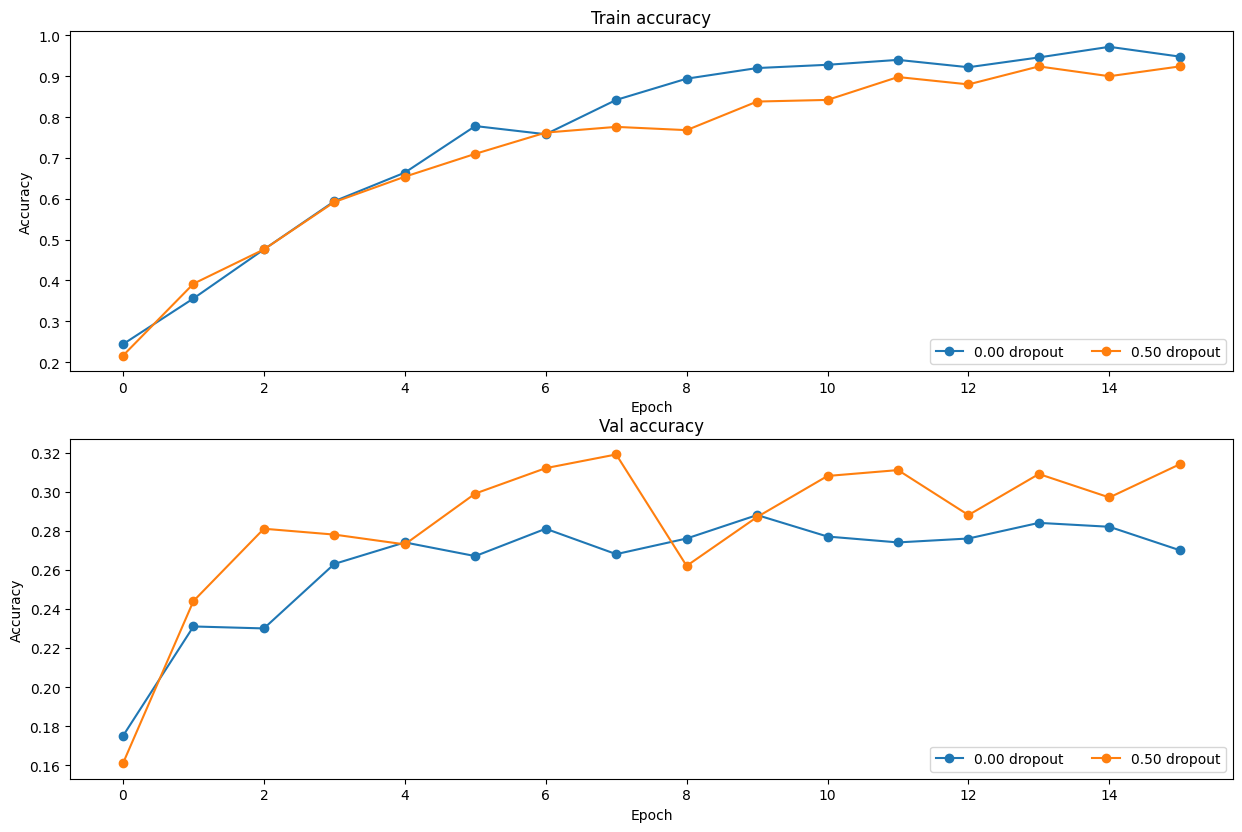

In [41]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
    solver = solvers[dropout]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])
    solver.record_histories_as_npz('submission_logs/dropout_regularization_experiment_p{}.npz'.format(dropout))

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].train_acc_history, '-o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].val_acc_history, '-o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

### Question:
**Explain what you see in this experiment. What does it suggest about dropout?** Write your answer on the written assignment.